# «Friedman Test» from Demsar (2006)
Adapted from cgosorio's work.
<br>
Author = Daniel Puente Ramírez

In [28]:
import os.path
import scipy.stats
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Orange.evaluation import compute_CD, graph_ranks
# from autorank import autorank, plot_stats, create_report, latex_table

In [29]:
metric = 'accuracy score'
results_path = os.path.join('ranks', 'results.csv')

In [30]:
results_df = pd.read_csv(results_path)

In [31]:
filters = results_df['filter'].unique()
base_estimators = results_df['base'].unique()
percents_labeled = results_df['percent labeled'].unique()
datasets = results_df['dataset'].unique()
percents_labeled.sort()

print(f"Base estimators used: {base_estimators}")
print(f"Filters used: {filters}")
print(f"Percents labeled used: {percents_labeled}")
print(f"# Datasets used: {len(datasets)}")


Base estimators used: ['KNeighborsClassifier' 'DecisionTreeClassifier' 'GaussianNB']
Filters used: ['ENN' 'LSSm' 'ENANE' 'base']
Percents labeled used: [ 0.050  0.100  0.150  0.200  0.250  0.300  0.350]
# Datasets used: 18


In [32]:
grouped_df = results_df.groupby(['dataset', 'percent labeled',
                                              'base', 'filter']).mean()

grouped_df = grouped_df[metric].to_frame()
grouped_df.reset_index(inplace=True)

bases_filters = np.array(list(product(base_estimators, filters)))
print("Pairs of base estimator with filters:\n", bases_filters)

Pairs of base estimator with filters:
 [['KNeighborsClassifier' 'ENN']
 ['KNeighborsClassifier' 'LSSm']
 ['KNeighborsClassifier' 'ENANE']
 ['KNeighborsClassifier' 'base']
 ['DecisionTreeClassifier' 'ENN']
 ['DecisionTreeClassifier' 'LSSm']
 ['DecisionTreeClassifier' 'ENANE']
 ['DecisionTreeClassifier' 'base']
 ['GaussianNB' 'ENN']
 ['GaussianNB' 'LSSm']
 ['GaussianNB' 'ENANE']
 ['GaussianNB' 'base']]


In [33]:
grouped_df.head(10)

,dataset,percent labeled,base,filter,accuracy score
0,BreastTissue.csv,0.05,DecisionTreeClassifier,ENANE,0.247273
1,BreastTissue.csv,0.05,DecisionTreeClassifier,ENN,0.262727
2,BreastTissue.csv,0.05,DecisionTreeClassifier,LSSm,0.260909
3,BreastTissue.csv,0.05,DecisionTreeClassifier,base,0.319091
4,BreastTissue.csv,0.05,GaussianNB,ENANE,0.225455
5,BreastTissue.csv,0.05,GaussianNB,ENN,0.197273
6,BreastTissue.csv,0.05,GaussianNB,LSSm,0.170909
7,BreastTissue.csv,0.05,GaussianNB,base,0.246364
8,BreastTissue.csv,0.05,KNeighborsClassifier,ENANE,0.330909
9,BreastTissue.csv,0.05,KNeighborsClassifier,ENN,0.200000


In [34]:
def base_filter_values():
    values = pd.DataFrame()
    for base_filter in bases_filters:
        base_, filter_ = base_filter
        working_df = grouped_df.loc[
            (grouped_df['percent labeled'] == percent) &
            (grouped_df['base'] == base_) &
            (grouped_df['filter'] == filter_)
            ]
        value = working_df[metric].to_frame()
        value.reset_index(inplace=True, drop=True)
        value.columns = [':'.join(base_filter)]
        values = pd.concat((value, values), axis=1)

    return values


def split_onto_base_estimators():
    for base_ in base_estimators:
        df = curr_vals.filter(regex=base_)
        base_dfs.append(df)
    
    return base_dfs

In [35]:
data = []

In [36]:
data = []
for percent in percents_labeled:
    curr_vals = base_filter_values()

    base_dfs = list()
    split_onto_base_estimators()
    # print('\n\n------------------------------------\n\n> Percent labeled: ',
    #       percent)
    for base, df in zip(base_estimators, base_dfs):
        metric_vals = df.to_numpy()

        N, k = len(datasets), len(df.columns)
        assert N==metric_vals.shape[0] and k==metric_vals.shape[1]
        
        rankings = scipy.stats.rankdata(-metric_vals, axis=1)

        Rj = average_ranks = np.mean(rankings, axis=0)

        average_rank_tuples = sorted(zip(df.columns, average_ranks), key=lambda
            a: a[1])
        
        average_rank_for = {method: value for method,
                                              value in zip(df.columns,
                                                           average_ranks)}
        # print()
        # for key, value in average_rank_for.items():
        #     print(key, f'{value:.2f}')
            
            
        part0 = (12*N)/(k*(k+1))
        part1 = sum([Rj**2 for Rj in average_ranks])
        part2 = (k*(k+1)**2)/4     
        𝛘2_F = part0*(part1-part2)
        F_F = (N-1)*𝛘2_F/(N*(k-1)-𝛘2_F)
        
        data.append([percent, F_F, average_rank_for, N, k])  

# Visualization of the Nemenyi and Bonferroni-Dunn Diagrams

<Figure size 6000x4000 with 0 Axes>

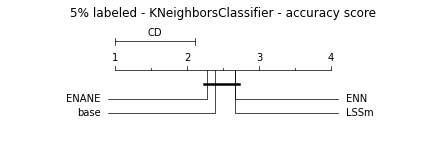

<Figure size 6000x4000 with 0 Axes>

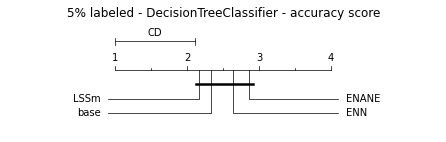

<Figure size 6000x4000 with 0 Axes>

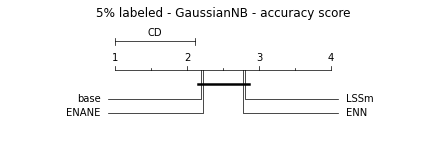

<Figure size 6000x4000 with 0 Axes>

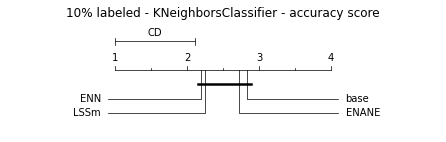

<Figure size 6000x4000 with 0 Axes>

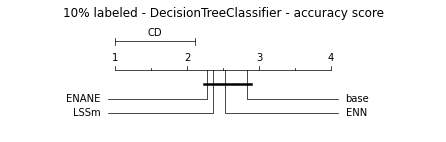

<Figure size 6000x4000 with 0 Axes>

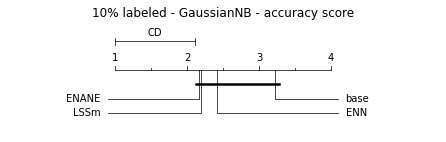

<Figure size 6000x4000 with 0 Axes>

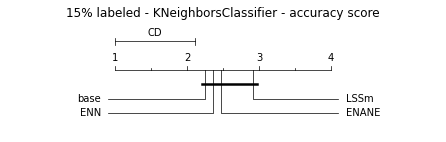

<Figure size 6000x4000 with 0 Axes>

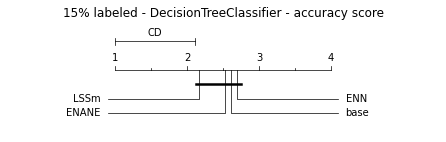

<Figure size 6000x4000 with 0 Axes>

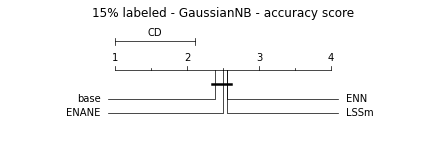

<Figure size 6000x4000 with 0 Axes>

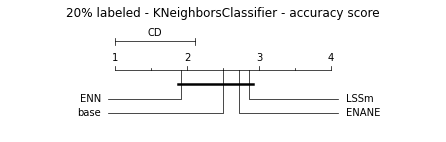

<Figure size 6000x4000 with 0 Axes>

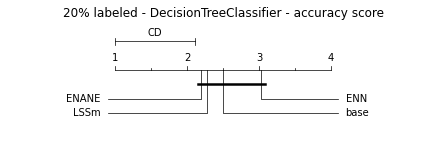

<Figure size 6000x4000 with 0 Axes>

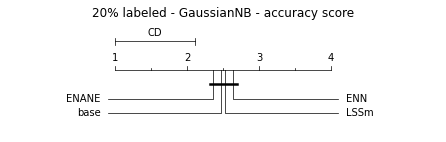

<Figure size 6000x4000 with 0 Axes>

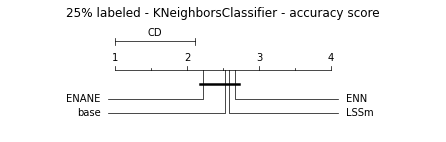

<Figure size 6000x4000 with 0 Axes>

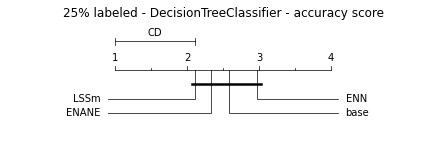

<Figure size 6000x4000 with 0 Axes>

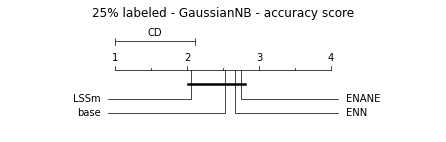

<Figure size 6000x4000 with 0 Axes>

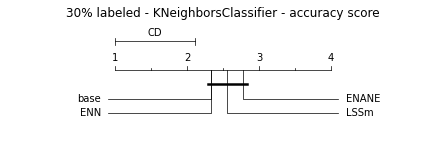

<Figure size 6000x4000 with 0 Axes>

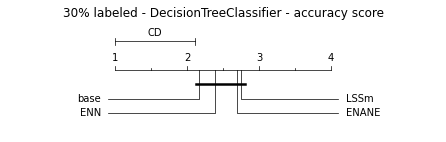

<Figure size 6000x4000 with 0 Axes>

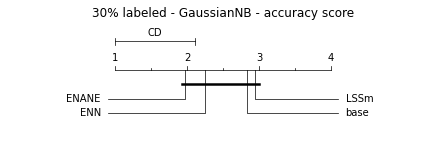

<Figure size 6000x4000 with 0 Axes>

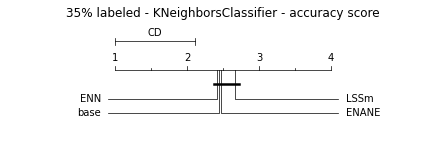

<Figure size 6000x4000 with 0 Axes>

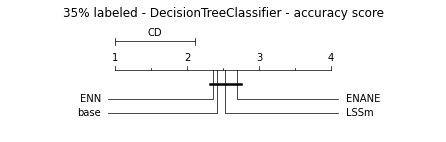

<Figure size 6000x4000 with 0 Axes>

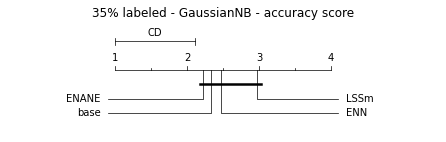

In [37]:
for percent, _, average_rank_for, _, _ in data:
    bases_ = list(average_rank_for.keys())
    filters_ = [x.split(':')[1] for x in bases_]
    base_name = bases_[0].split(':')[0]
    avranks = list(average_rank_for.values())
    
    cd = compute_CD(avranks, len(datasets))
    
    fig = plt.figure(dpi=1000)
    graph_ranks(avranks=avranks, names=filters_, cd=cd, textspace=1.5)
    plt.title(f"{int(percent * 100)}% labeled - {base_name} - {metric}")
    plt.savefig(os.path.join('result_plots', f'{percent}_{base_name}.png'), dpi=1000, bbox_inches='tight')
    plt.show()  